In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import time
import matplotlib.pyplot as plt

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def load_data(batch_size=256):
    transform = transforms.ToTensor()
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

def softmax(X):
    # 数值稳定：减去最大值
    X_exp = torch.exp(X - torch.max(X, dim=1, keepdim=True).values)
    partition = torch.sum(X_exp, dim=1, keepdim=True)
    return X_exp / partition

def cross_entropy(y_hat, y):
    """
    y_hat: (batch_size, num_classes) 的预测概率
    y: (batch_size,) 的真实标签（整数）
    """
    # 使用 log(softmax) 等价于 log(y_hat)，但更稳定
    # 但我们这里直接用 y_hat（已 softmax）
    # 避免除零：加一个极小值
    epsilon = 1e-12
    y_hat = torch.clamp(y_hat, epsilon, 1.0 - epsilon)
    log_probs = torch.log(y_hat)
    # 取出真实类别的 log 概率
    log_likelihood = -log_probs.gather(1, y.unsqueeze(1)).squeeze(1)
    return torch.mean(log_likelihood)

def init_params(num_inputs, num_outputs, device):
    W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True, device=device)
    b = torch.zeros(num_outputs, requires_grad=True, device=device)
    return W, b

def net(X, W, b):
    # X shape: (batch_size, 784)
    linear = torch.matmul(X, W) + b  # (batch_size, 10)
    return softmax(linear)

def accuracy(y_hat, y):
    """计算预测正确的数量"""
    pred = torch.argmax(y_hat, dim=1)
    return (pred == y).float().sum().item()

def train_epoch(train_loader, W, b, lr, device):
    total_loss = 0.0
    total_acc = 0.0
    n_samples = 0

    for X, y in train_loader:
        X = X.view(X.shape[0], -1).to(device)  # flatten to (batch, 784)
        y = y.to(device)

        # 前向
        y_hat = net(X, W, b)
        loss = cross_entropy(y_hat, y)

        # 反向传播（手动）
        loss.backward()

        # 更新参数（SGD）
        with torch.no_grad():
            W -= lr * W.grad
            b -= lr * b.grad
            # 清零梯度
            W.grad.zero_()
            b.grad.zero_()

        # 累计指标
        total_loss += loss.item() * X.shape[0]
        total_acc += accuracy(y_hat, y)
        n_samples += X.shape[0]

    avg_loss = total_loss / n_samples
    avg_acc = total_acc / n_samples
    return avg_loss, avg_acc

def evaluate(test_loader, W, b, device):
    total_acc = 0.0
    n_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for X, y in test_loader:
            X = X.view(X.shape[0], -1).to(device)
            y = y.to(device)
            y_hat = net(X, W, b)
            loss = cross_entropy(y_hat, y)

            total_loss += loss.item() * X.shape[0]
            total_acc += accuracy(y_hat, y)
            n_samples += X.shape[0]

    avg_loss = total_loss / n_samples
    avg_acc = total_acc / n_samples
    return avg_loss, avg_acc

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    batch_size = 256
    lr = 0.1
    num_epochs = 20
    num_inputs = 28 * 28
    num_outputs = 10

    train_loader, test_loader = load_data(batch_size)

    W, b = init_params(num_inputs, num_outputs, device)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(train_loader, W, b, lr, device)
        test_loss, test_acc = evaluate(test_loader, W, b, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f} | "
              f"Time: {time.time() - start_time:.2f}s")

    # 最终结果分析
    print("\n✅ Training completed.")
    print(f"Final Test Accuracy: {test_accs[-1]:.4f}")
    print(f"Best Test Accuracy: {max(test_accs):.4f}")

    # 可选：绘制曲线（需 matplotlib）
    # try:
    #     import matplotlib.pyplot as plt
    # AI写的做开始画图是使用try except的方式尝试，后续主动修改为在前米直接导入，并调整缩进
    
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, test_accs, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # except ImportError:
    #     print("Matplotlib not available for plotting.")

    return train_losses, train_accs, test_losses, test_accs # 此行为新加的返回




Using device: cuda
Epoch 1/20 | Train Loss: 0.7869, Train Acc: 0.7483 | Test Loss: 0.6360, Test Acc: 0.7872 | Time: 6.04s
Epoch 2/20 | Train Loss: 0.5705, Train Acc: 0.8124 | Test Loss: 0.5761, Test Acc: 0.8016 | Time: 5.17s
Epoch 3/20 | Train Loss: 0.5262, Train Acc: 0.8250 | Test Loss: 0.5446, Test Acc: 0.8138 | Time: 5.21s
Epoch 4/20 | Train Loss: 0.5016, Train Acc: 0.8314 | Test Loss: 0.5290, Test Acc: 0.8203 | Time: 5.59s
Epoch 5/20 | Train Loss: 0.4856, Train Acc: 0.8366 | Test Loss: 0.5228, Test Acc: 0.8216 | Time: 5.82s
Epoch 6/20 | Train Loss: 0.4741, Train Acc: 0.8396 | Test Loss: 0.4978, Test Acc: 0.8284 | Time: 6.49s
Epoch 7/20 | Train Loss: 0.4651, Train Acc: 0.8419 | Test Loss: 0.5078, Test Acc: 0.8243 | Time: 5.64s
Epoch 8/20 | Train Loss: 0.4578, Train Acc: 0.8445 | Test Loss: 0.4840, Test Acc: 0.8320 | Time: 5.84s
Epoch 9/20 | Train Loss: 0.4515, Train Acc: 0.8463 | Test Loss: 0.4875, Test Acc: 0.8307 | Time: 6.45s
Epoch 10/20 | Train Loss: 0.4471, Train Acc: 0.8479 | 

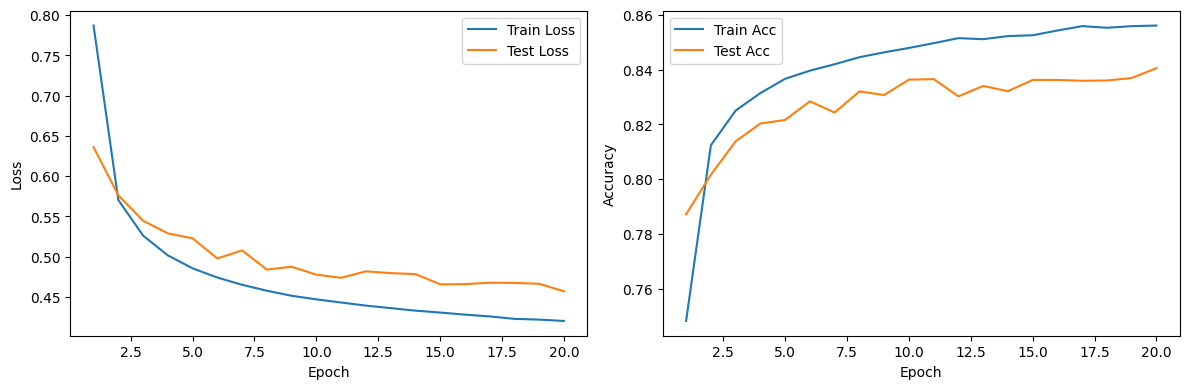

In [ ]:
if __name__ == "__main__":
    manual_train_losses, manual_train_accs, manual_test_losses, manual_test_accs = main()
    

In [4]:
import torch.nn as nn
import torch.optim as optim

In [5]:
class SoftmaxRegression(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    
    def forward(self, x):
        # 输入 x: (batch_size, 1, 28, 28) → 需 flatten
        x = x.view(x.shape[0], -1)  # (batch_size, 784)
        return self.linear(x)       # 输出 logits，不加 softmax！
    

def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)               # logits
        loss = criterion(outputs, y)     # criterion = CrossEntropyLoss
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc


def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)

            total_loss += loss.item() * X.size(0)
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc

def main_nn():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    batch_size = 256
    lr = 0.1
    num_epochs = 20
    num_inputs = 28 * 28
    num_outputs = 10

    train_loader, test_loader = load_data(batch_size)

    model = SoftmaxRegression(num_inputs, num_outputs).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"[nn] Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f} | "
              f"Time: {time.time() - start_time:.2f}s")

    print(f"\n✅ [nn] Final Test Accuracy: {test_accs[-1]:.4f}")
    print(f"[nn] Best Test Accuracy: {max(test_accs):.4f}")

    return train_losses, train_accs, test_losses, test_accs

# 运行 torch.nn 版本
nn_train_losses, nn_train_accs, nn_test_losses, nn_test_accs = main_nn()

Using device: cuda
[nn] Epoch 1/20 | Train Loss: 0.7875, Train Acc: 0.7470 | Test Loss: 0.6324, Test Acc: 0.7874 | Time: 5.93s
[nn] Epoch 2/20 | Train Loss: 0.5716, Train Acc: 0.8132 | Test Loss: 0.5642, Test Acc: 0.8121 | Time: 8.60s
[nn] Epoch 3/20 | Train Loss: 0.5254, Train Acc: 0.8252 | Test Loss: 0.5501, Test Acc: 0.8126 | Time: 7.14s
[nn] Epoch 4/20 | Train Loss: 0.5010, Train Acc: 0.8336 | Test Loss: 0.5190, Test Acc: 0.8230 | Time: 5.75s
[nn] Epoch 5/20 | Train Loss: 0.4850, Train Acc: 0.8367 | Test Loss: 0.5082, Test Acc: 0.8276 | Time: 5.49s
[nn] Epoch 6/20 | Train Loss: 0.4741, Train Acc: 0.8401 | Test Loss: 0.5219, Test Acc: 0.8201 | Time: 5.31s
[nn] Epoch 7/20 | Train Loss: 0.4653, Train Acc: 0.8429 | Test Loss: 0.4992, Test Acc: 0.8290 | Time: 5.36s
[nn] Epoch 8/20 | Train Loss: 0.4587, Train Acc: 0.8444 | Test Loss: 0.4912, Test Acc: 0.8315 | Time: 5.32s
[nn] Epoch 9/20 | Train Loss: 0.4519, Train Acc: 0.8467 | Test Loss: 0.4814, Test Acc: 0.8345 | Time: 5.90s
[nn] Epoc

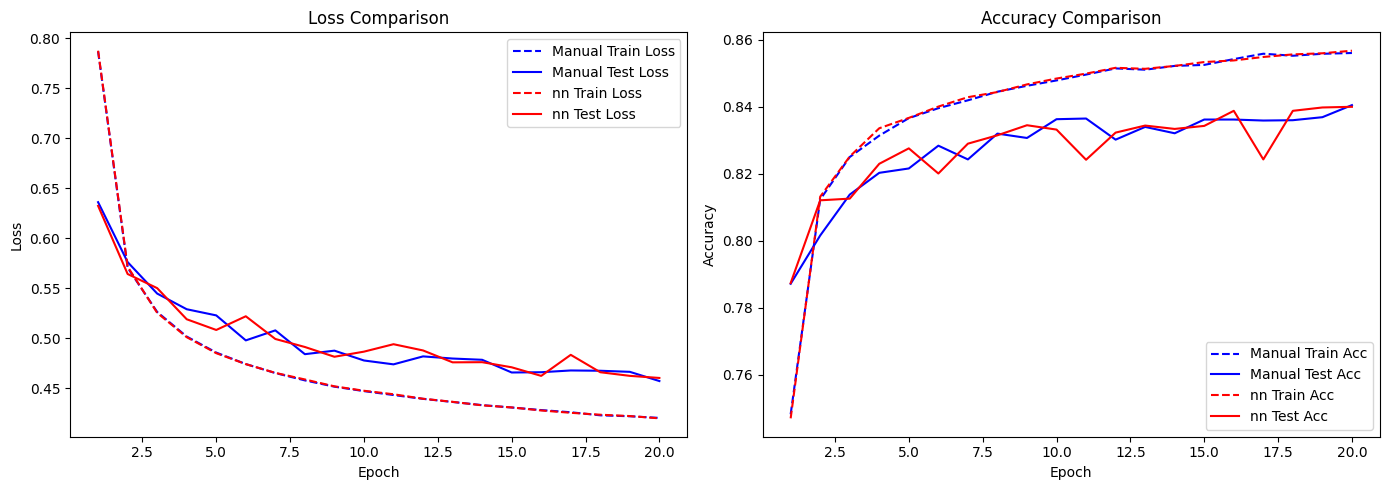

In [6]:
epochs = range(1, len(nn_train_losses) + 1)

plt.figure(figsize=(14, 5))

# Loss 对比
plt.subplot(1, 2, 1)
plt.plot(epochs, manual_train_losses, 'b--', label='Manual Train Loss')
plt.plot(epochs, manual_test_losses, 'b-', label='Manual Test Loss')
plt.plot(epochs, nn_train_losses, 'r--', label='nn Train Loss')
plt.plot(epochs, nn_test_losses, 'r-', label='nn Test Loss')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy 对比
plt.subplot(1, 2, 2)
plt.plot(epochs, manual_train_accs, 'b--', label='Manual Train Acc')
plt.plot(epochs, manual_test_accs, 'b-', label='Manual Test Acc')
plt.plot(epochs, nn_train_accs, 'r--', label='nn Train Acc')
plt.plot(epochs, nn_test_accs, 'r-', label='nn Test Acc')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()